In [1]:
from wave_equations.elastic.ElasticIsotropic2D import ElasticIsotropic2D

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate

In [2]:
def model_half_space(n_x,n_z,val1,val2,interface_z_index=None,angle=None):
  model = np.zeros((n_x, n_z))
  if interface_z_index is None:
    interface_z_index = n_z // 2
  model[:, :interface_z_index] = val1
  model[:, interface_z_index:] = val2
  if angle is not None:
    model = rotate(model, angle=angle, mode='reflect',reshape=False)
  return model

def ricker(f, length=0.128, dt=0.001):
    t = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

## Use ElasticIsotropic2D wave equation with only numpy arrays

Make a half space pressure-wave velocity model. Also make evenly spaced sources and receivers at the surface.

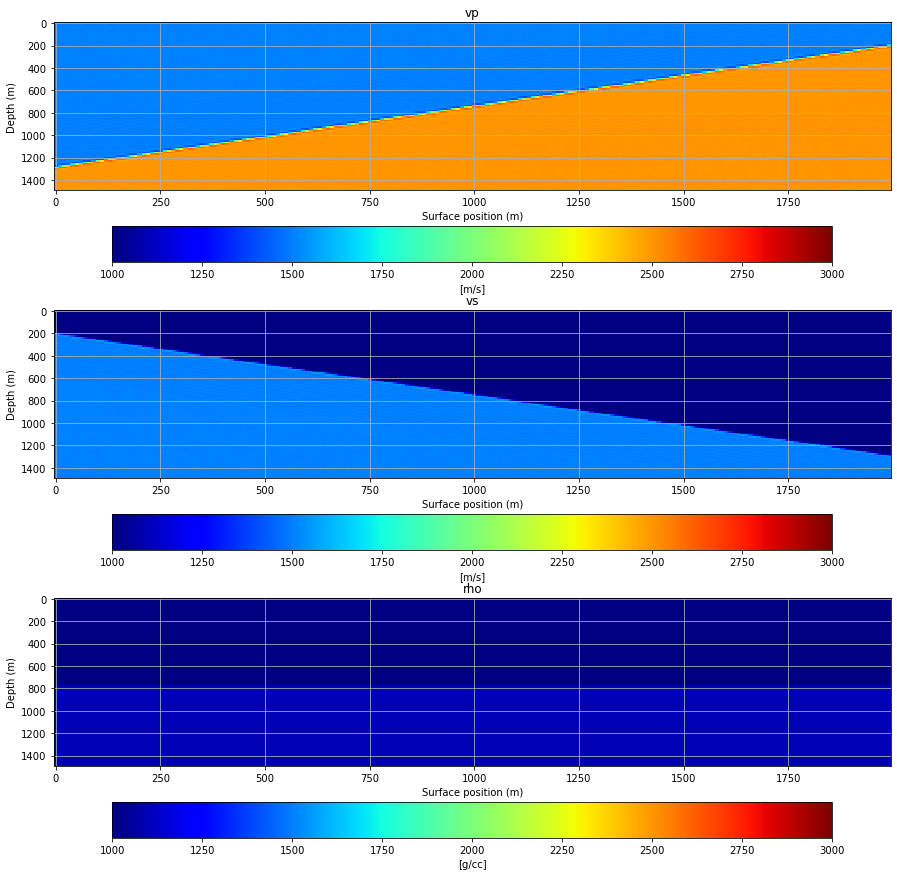

In [3]:
# make model
n_x = 200
d_x = 10.0
n_z = 100
d_z = 15.0
vp_1 = 1500
vp_2 = 2500
vs_1 = 1000
vs_2 = 1500
rho_1 = 1000
rho_2 = 1100
vp_model = model_half_space(n_x,n_z,vp_1,vp_2,interface_z_index=50,angle=-20)
vs_model = model_half_space(n_x,n_z,vs_1,vs_2,interface_z_index=50,angle=20)
rho_model = model_half_space(n_x,n_z,rho_1,rho_2,interface_z_index=52,angle=0)
ela_model = np.array([vp_model,vs_model,rho_model])

fig, axs = plt.subplots(3, figsize=(15, 15))
for ax, ela_param,label in zip(axs,ela_model,[('vp','[m/s]'),('vs','[m/s]'),('rho','[g/cc]')]):
    img = ax.pcolormesh(np.arange(n_x)*d_x,np.arange(n_z)*d_z,ela_param.T,cmap='jet',vmin=1000,vmax=3000)
    ax.invert_yaxis()
    ax.grid()
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Surface position (m)')
    ax.set_title(label[0])
    fig.colorbar(img, ax=ax, orientation="horizontal", label=label[1])

In [4]:
# make evenly spaced source and receiver positions
n_src=20
o_x_src=0.0
d_x_src=n_x*d_x//n_src
z_src=10.0
n_rec=n_x
o_x_rec=0.0
d_x_rec=d_x
z_rec=10.0
src_x_locations = o_x_src + np.arange(n_src) * d_x_src
src_z_locations = np.ones_like(src_x_locations) * z_src
src_locations = np.array([src_x_locations,src_z_locations]).T
rec_x_locations = o_x_rec + np.arange(n_rec) * d_x_rec
rec_z_locations = np.ones_like(rec_x_locations) * z_rec
rec_locations = np.array([rec_x_locations,rec_z_locations]).T

Make a Ricker trace and make an 2D elastic wavelet 

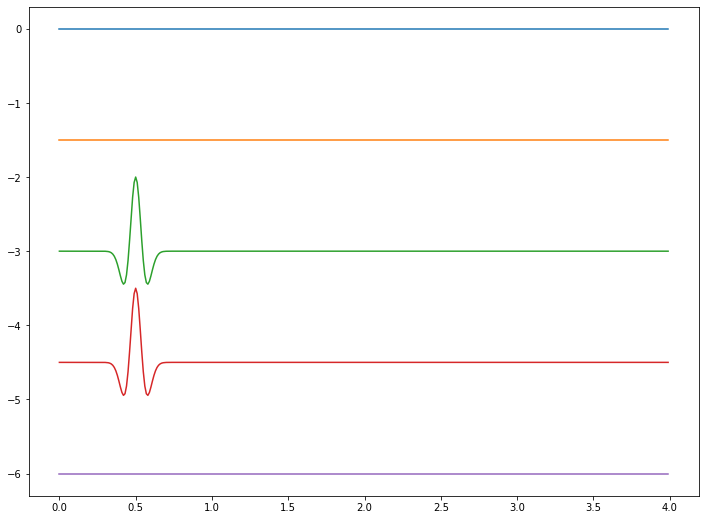

In [5]:
n_t = 400
d_t = 0.01
delay = 0.5
dom_freq = 5.0

t, wavelet_arr = ricker(dom_freq,length=n_t*d_t,dt=d_t)
t -= t[0]
shift = int(delay/d_t) - n_t//2
ricker_arr = np.roll(wavelet_arr, shift)

wavelet_arr = np.zeros((5,n_t))
wavelet_arr[2] = ricker_arr
wavelet_arr[3] = ricker_arr
plt.figure(figsize=(12,9))
for i_param, source_param in enumerate(wavelet_arr):
    plt.plot(t,source_param-1.5*i_param)

In [6]:
elastic_2d = ElasticIsotropic2D(model=ela_model,
               model_sampling=(d_x, d_z),
               model_padding=(100,100),
               wavelet=wavelet_arr,
               d_t=d_t,
               src_locations=src_locations,
               rec_locations=rec_locations,
               gpus=[0,1,2,3])

In [7]:
%%time
data = elastic_2d.fwd(ela_model)

CPU times: user 16.5 s, sys: 3.53 s, total: 20.1 s
Wall time: 2.46 s


In [8]:
# sample pressure
pressure_data = 0.5 * (data[:,2] + data[:,3])

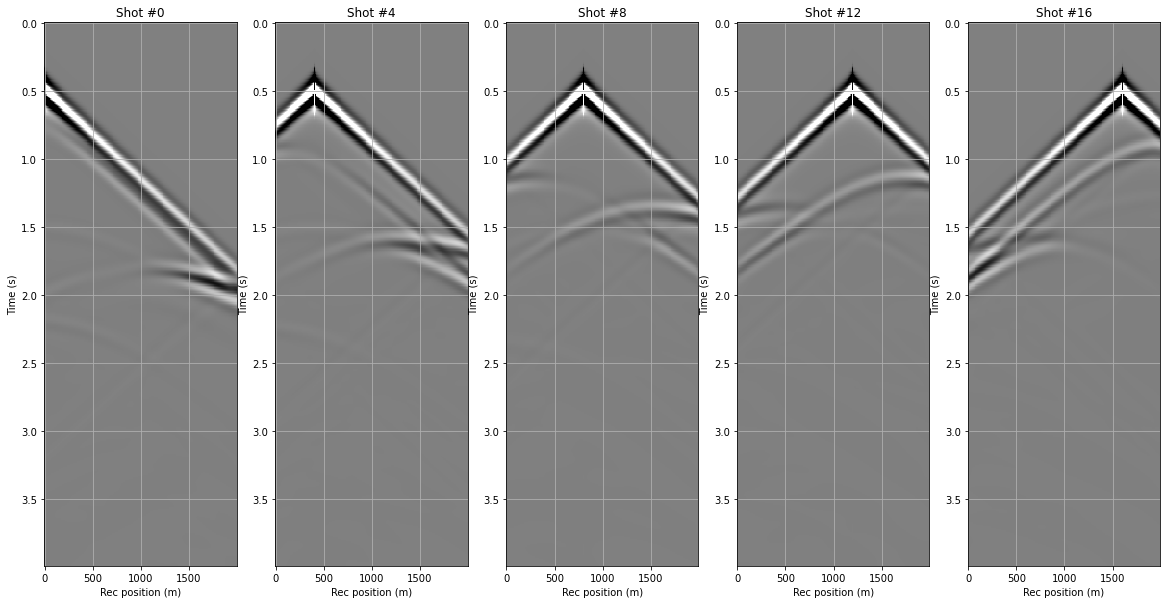

In [9]:
# Display shot gathers
clip = np.percentile(np.abs(pressure_data),99)
fig, axs = plt.subplots(1,5, figsize=(20, 10))
shot_skip=4
for shot_number, (ax, shot) in enumerate(zip(axs,pressure_data[::shot_skip])):
    ax.pcolormesh(rec_locations[:,0],np.arange(n_t)*d_t,shot.T,cmap='gray',vmin=-clip,vmax=clip)
    ax.invert_yaxis()
    ax.grid()
    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Rec position (m)')
    ax.set_title(f'Shot #{shot_number*shot_skip}')

## Use ElasticIsotropic2D with Wavelet and Acquisition classes

In [11]:
from geometries import Geometry
from wavelets.elastic import Elastic2D

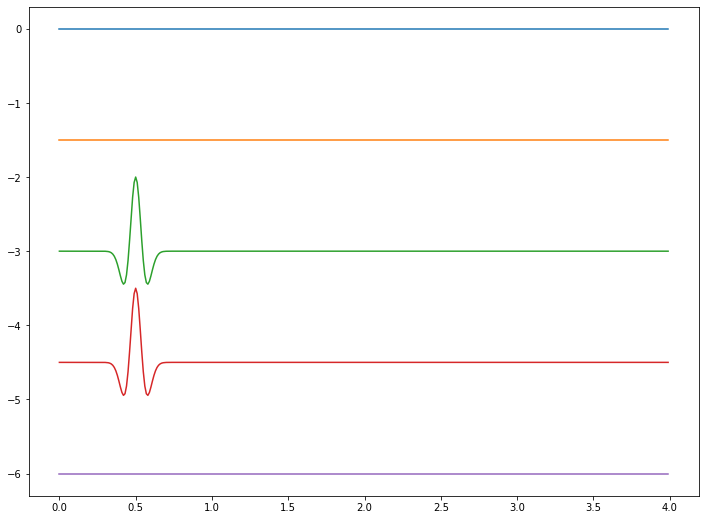

In [14]:
elastic_isotropic_ricker = Elastic2D.ElasticIsotropicRicker2D(n_t,d_t,dom_freq,delay)

hydrophone_full_acquisition = Geometry.Full2D(n_src=n_src,
                                        o_x_src=o_x_src,
                                        d_x_src=d_x_src,
                                        z_src=z_src,
                                        n_rec=n_rec,
                                        o_x_rec=o_x_rec,
                                        d_x_rec=d_x_rec,
                                        z_rec=z_rec)
src_locations = hydrophone_full_acquisition.get_src_positions()
rec_locations = hydrophone_full_acquisition.get_rec_positions()

plt.figure(figsize=(12,9))
for i_param, source_param in enumerate(elastic_isotropic_ricker.arr):
    plt.plot(t,source_param-1.5*i_param)

In [15]:
%%time
elastic_2d = ElasticIsotropic2D(model=ela_model,
               model_sampling=(d_x, d_z),
               model_padding=(100,100),
               wavelet=elastic_isotropic_ricker.arr,
               d_t=d_t,
               src_locations=src_locations,
               rec_locations=rec_locations,
               gpus=[0,1,2,3])
data = elastic_2d.fwd(ela_model)
hydrophone_data = np.mean(data[:,2:4],axis=1)

CPU times: user 22.4 s, sys: 5.95 s, total: 28.3 s
Wall time: 3.94 s


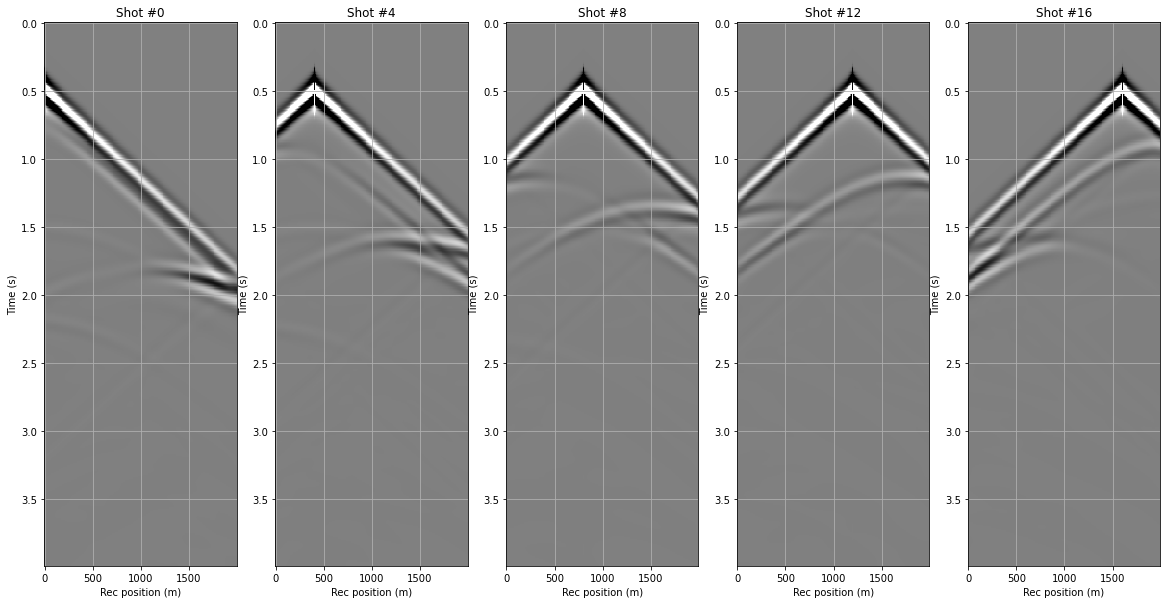

In [16]:
# Display shot gathers
clip = np.percentile(np.abs(hydrophone_data),99)
fig, axs = plt.subplots(1,5, figsize=(20, 10))
shot_skip=4
for shot_number, (ax, shot) in enumerate(zip(axs,hydrophone_data[::shot_skip])):
    ax.pcolormesh(rec_locations[:,0],np.arange(n_t)*d_t,shot.T,cmap='gray',vmin=-clip,vmax=clip)
    ax.invert_yaxis()
    ax.grid()
    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Rec position (m)')
    ax.set_title(f'Shot #{shot_number*shot_skip}')

## Streamer Acquisition

In [17]:
n_src = 10
n_rec = 75
o_x_rec= -15.0
d_x_rec= -d_x
o_x_src = 1000
hydrophone_streamer_acquisition = Geometry.Streamer2D(n_src=n_src,
                                        o_x_src=o_x_src,
                                        d_x_src=d_x_src,
                                        z_src=z_src,
                                        n_rec=n_rec,
                                        o_x_rec=o_x_rec,
                                        d_x_rec=d_x_rec,
                                        z_rec=z_rec)
src_locations = hydrophone_streamer_acquisition.get_src_positions()
rec_locations = hydrophone_streamer_acquisition.get_rec_positions()

In [18]:
%%time
elastic_2d = ElasticIsotropic2D(model=ela_model,
               model_sampling=(d_x, d_z),
               model_padding=(100,100),
               wavelet=elastic_isotropic_ricker.arr,
               d_t=d_t,
               src_locations=src_locations,
               rec_locations=rec_locations,
               gpus=[0,1,2,3])
data = elastic_2d.fwd(ela_model)
hydrophone_streamer_data = np.mean(data[:,2:4],axis=1)

CPU times: user 11.7 s, sys: 1.48 s, total: 13.2 s
Wall time: 1.1 s


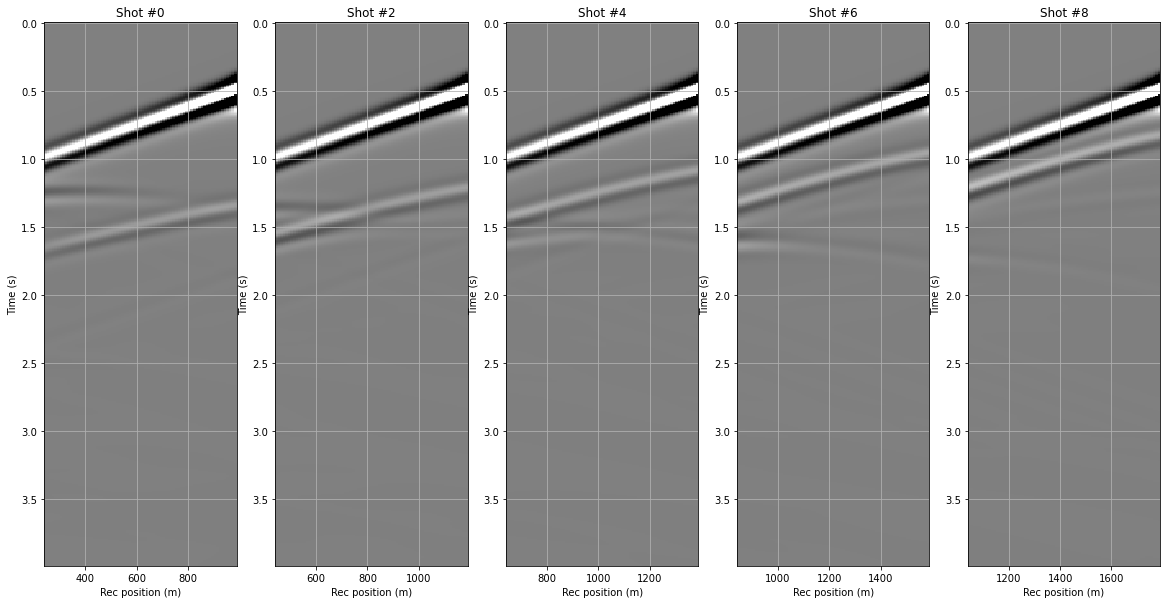

In [19]:
# Display shot gathers
clip = np.percentile(np.abs(hydrophone_streamer_data),98)
fig, axs = plt.subplots(1,5, figsize=(20, 10))
shot_skip=2
for shot_number, (ax, shot, rec_loc) in enumerate(zip(axs,hydrophone_streamer_data[::shot_skip],rec_locations[::shot_skip])):
    ax.pcolormesh(rec_loc[:,0],np.arange(n_t)*d_t,shot.T,cmap='gray',vmin=-clip,vmax=clip)
    ax.invert_yaxis()
    ax.grid()
    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Rec position (m)')
    ax.set_title(f'Shot #{shot_number*shot_skip}')